In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
from IPython.display import display 
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score

# Data Cleaning

In [2]:
starData = pd.read_csv('./star_type_data.csv')
starData.head()
starData.isnull().sum()

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
Spectral Class            0
dtype: int64

## Converting Spectral Class Variable with One-Hot Encoding

In [3]:
print(starData["Spectral Class"].value_counts())
starData = starData.join(pd.get_dummies(starData["Spectral Class"]))
starData = starData.drop('Spectral Class',axis = 1)
starData.head()

M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: Spectral Class, dtype: int64


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,A,B,F,G,K,M,O
0,3068,0.002400,0.1700,16.12,0,Red,0,0,0,0,0,1,0
1,3042,0.000500,0.1542,16.60,0,Red,0,0,0,0,0,1,0
2,2600,0.000300,0.1020,18.70,0,Red,0,0,0,0,0,1,0
3,2800,0.000200,0.1600,16.65,0,Red,0,0,0,0,0,1,0
4,1939,0.000138,0.1030,20.06,0,Red,0,0,0,0,0,1,0


## Converting Star color Variable with One-Hot Encoding

In [4]:
starData["Star color"].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Orange                  2
yellowish               2
Whitish                 2
Yellowish               1
Pale yellow orange      1
Blue                    1
Blue-White              1
White-Yellow            1
Blue white              1
Orange-Red              1
Name: Star color, dtype: int64

In [5]:
starData["Star color"] = starData["Star color"].str.replace(' ', '')
starData["Star color"] = starData["Star color"].str.replace('-', '')
starData["Star color"] = starData["Star color"].str.lower()
starData["Star color"].value_counts()

red                 112
blue                 56
bluewhite            41
white                10
yellowwhite           8
yellowish             3
yellowishwhite        3
whitish               2
orange                2
whiteyellow           1
paleyelloworange      1
orangered             1
Name: Star color, dtype: int64

In [6]:
starData["Star color"].replace('yellowishwhite','yellowwhite', inplace=True)
starData["Star color"].replace('whiteyellow','yellowwhite', inplace=True)
starData["Star color"].replace('whitish','white', inplace=True)
starData["Star color"].replace('orangered','orange', inplace=True)
starData["Star color"].replace('paleyelloworange','orange', inplace=True)
starData["Star color"].value_counts()

red            112
blue            56
bluewhite       41
yellowwhite     12
white           12
orange           4
yellowish        3
Name: Star color, dtype: int64

In [7]:
starData = starData.join(pd.get_dummies(starData["Star color"]))
starData = starData.drop('Star color',axis = 1)
final_starData = starData
final_starData.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,A,B,F,G,K,M,O,blue,bluewhite,orange,red,white,yellowish,yellowwhite
0,3068,0.002400,0.1700,16.12,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,3042,0.000500,0.1542,16.60,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,2600,0.000300,0.1020,18.70,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
3,2800,0.000200,0.1600,16.65,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,1939,0.000138,0.1030,20.06,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


## Data Visualization
Here we plot some of the variables to get a grasp of how the data is distributed

//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


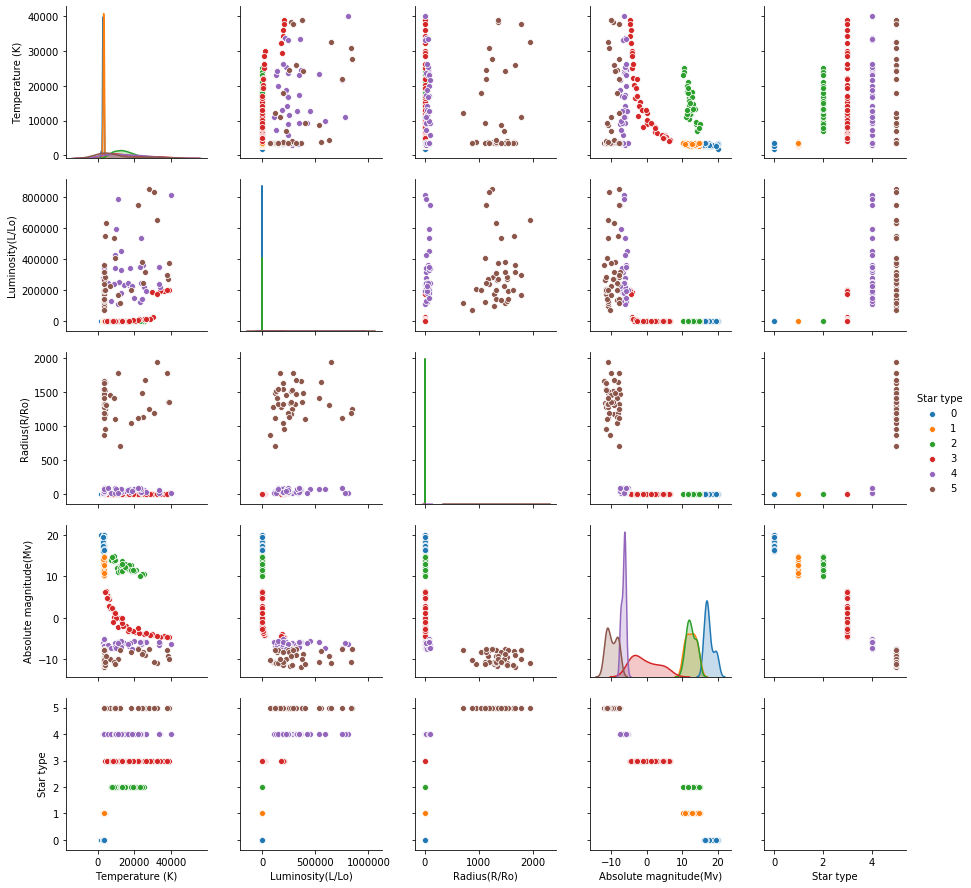

In [8]:
scatterplot = sns.pairplot(starData[['Temperature (K)','Luminosity(L/Lo)','Radius(R/Ro)',
                     'Absolute magnitude(Mv)', 'Star type']], hue="Star type")

# Proof of Concept: Clustering w/o PCA

In observing some of the plots above (especially Temperature plotted against Absolute magnitude), it appears that our continuous data may be immediately separable into groups using one of our clustering algorithms. Below, we demonstrate that this is not the case; the variability present in the other dimensions seems to interfere with the results of the spectral clustering algorithm.

In [9]:
cont_data = starData.copy()
cont_data = cont_data.drop(['Star type'], axis = 1)
rm_labels = cont_data.columns[4:]
cont_data = cont_data.drop(rm_labels, axis = 1)

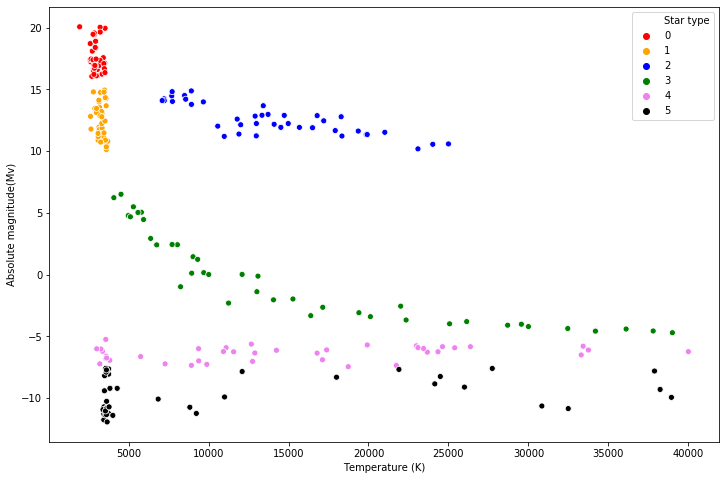

In [10]:
plt.figure(figsize = (12,8))
sns.scatterplot(cont_data['Temperature (K)'], cont_data['Absolute magnitude(Mv)'], hue = starData['Star type'], 
                palette = ['red', 'orange', 'blue', 'green', 'violet', 'black'])

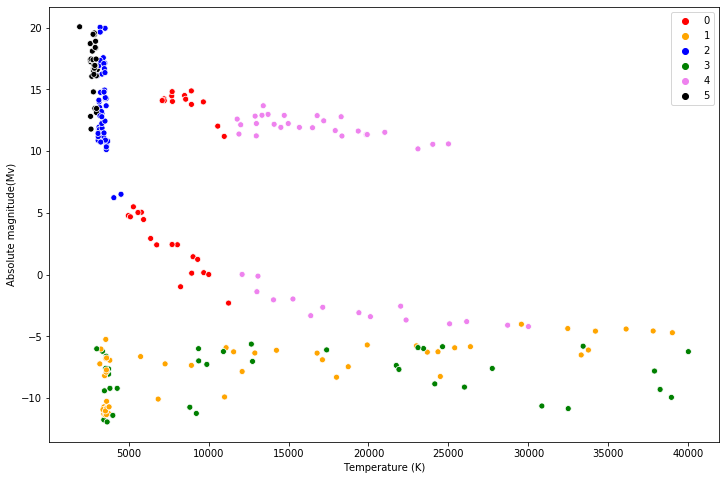

In [11]:
spec_clusters = SpectralClustering(n_clusters = 6, affinity= 'nearest_neighbors', n_neighbors = 15).fit(cont_data)
plt.figure(figsize=(12,8))
sns.scatterplot(cont_data['Temperature (K)'], cont_data['Absolute magnitude(Mv)'], hue = spec_clusters.labels_, 
                palette = ['red', 'orange', 'blue', 'green', 'violet', 'black'])

After running the algorithm several times with different n_neighbors parameters, it is clear that we cannot get our desired results with the data in this form. In order to get clean results from the clustering algorithm, we will re-represent the variability of the data using Principal Components Analysis.

# PCA

Next, we perform PCA on the data. In the following section, we run PCA twice on the dataset. The first time we include the one-hot categorical data and the second time we only include the 4 continous variables.

## PCA with complete dataset

In [12]:
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort

In [13]:
# copy the dataframe and remove the label
data_woLabel = starData.copy()
data_woLabel = data_woLabel.drop(['Star type'], axis=1)

In [14]:
# Normalizing the data
data_woLabel = StandardScaler().fit_transform(data_woLabel)
data_woLabel = pd.DataFrame(data_woLabel)

Z = np.zeros((18,240))
meandata=[]
for i in range(18):
    Z[i]=data_woLabel.iloc[:, i] - np.mean(data_woLabel.iloc[:, i])
    meandata.append(np.mean(data_woLabel.iloc[:, i]))

meandata= np.array(meandata)
meandata.shape

(18,)

In [15]:
n = 240
Z_T = np.transpose(Z)
covmatrix = np.matmul(Z, Z_T)*(1/n)
eigvals, V = np.linalg.eig(covmatrix)

In [16]:
# Sort the eigenvectors based on eigenvalues
Vnew, Dnew = eigsort(V, eigvals)

# Find principal compenent coordinates
c_full_data = np.matmul(Vnew.T,Z)

### Complete Data Set PCA Visualizations

//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


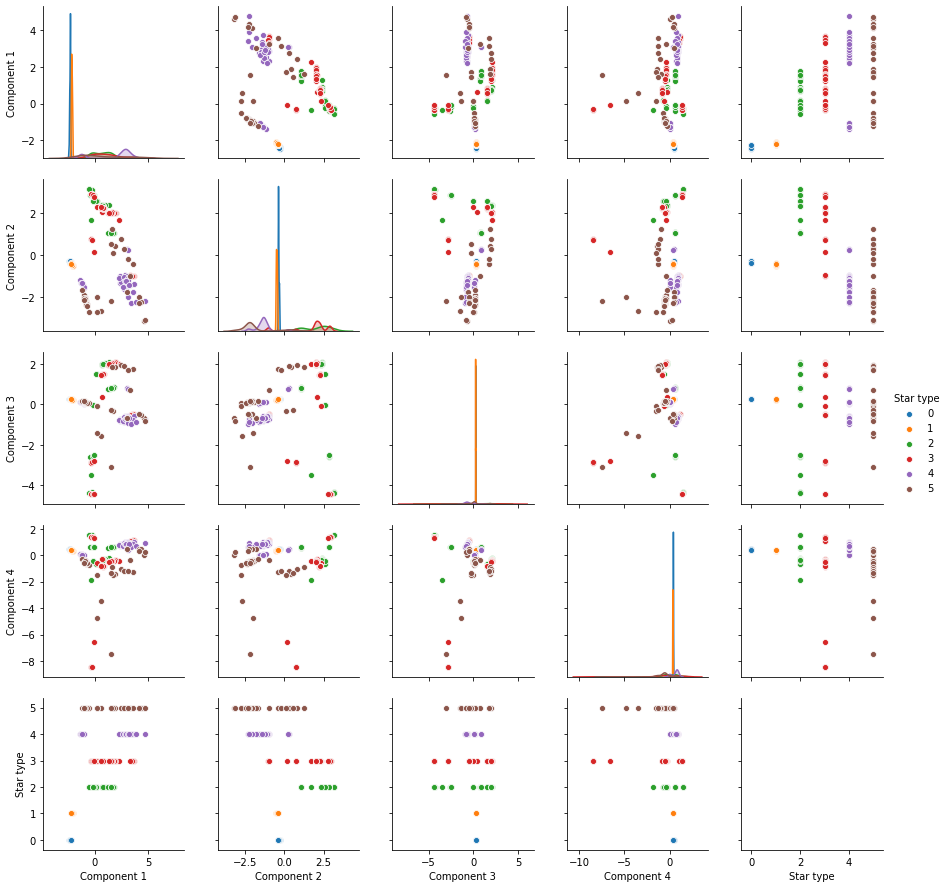

In [17]:
pca_fulldata_dataframe = pd.DataFrame(data=c_full_data).transpose()
pca_fulldata_dataframe['Star type'] = starData['Star type']
pca_fulldata_dataframe.columns = ['Component 1','Component 2','Component 3',
                     'Component 4','Component 5','Component 6', 'Component 7','Component 8','Component 9',
                    'Component 10','Component 11','Component 12', 'Component 13','Component 14','Component 15',
                    'Component 16','Component 17','Component 18', 'Star type']
scatterplot = sns.pairplot(pca_fulldata_dataframe[['Component 1','Component 2','Component 3',
                     'Component 4','Star type']], hue="Star type")

[0.23767583 0.38423751 0.49809249 0.60390734 0.6935825  0.77375909
 0.83087344 0.88222165 0.92610408 0.94551164 0.96019495 0.97370082
 0.98472508 0.99456138 0.9996324  1.         1.         1.        ]


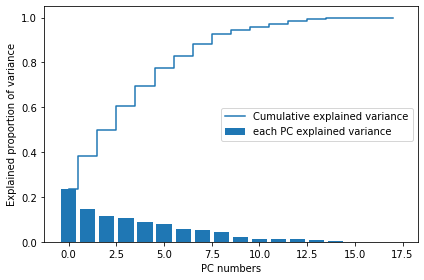

In [18]:

total_egnvalues = sum(eigvals)
exp_prop_var=[]
for i in (eigvals):
    exp_prop_var.append(i/total_egnvalues) 
                 
cum_exp_var = np.cumsum(exp_prop_var)
# visualizing culmulative expalined and variance and the number of PC that it needs to get there
print(cum_exp_var)
plt.bar(range(0,len(exp_prop_var)), exp_prop_var, label='each PC explained variance')
plt.step(range(0,len(cum_exp_var)), cum_exp_var, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained proportion of variance')
plt.xlabel('PC numbers')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## PCA with only continous data

Below, we perform PCA again on the dataset without the categorical variables

In [19]:
# copy the dataframe and remove the label
data_woLabel = starData.copy()
data_woLabel = data_woLabel.drop(['Star type'], axis=1)
labels = data_woLabel.columns[4:]
data_woLabel = data_woLabel.drop(labels, axis = 1)
data_woLabel.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
0,3068,0.002400,0.1700,16.12
1,3042,0.000500,0.1542,16.60
2,2600,0.000300,0.1020,18.70
3,2800,0.000200,0.1600,16.65
4,1939,0.000138,0.1030,20.06


Next, we normalize the data.

In [20]:
data_woLabel = StandardScaler().fit_transform(data_woLabel)
data_woLabel = pd.DataFrame(data_woLabel)

Z = np.zeros((4,240))
meandata=[]
for i in range(4):
    Z[i]=data_woLabel.iloc[:, i] - np.mean(data_woLabel.iloc[:, i])
    meandata.append(np.mean(data_woLabel.iloc[:, i]))

meandata= np.array(meandata)
meandata.shape

(4,)

In [21]:
n = 240
Z_T = np.transpose(Z)
covmatrix = np.matmul(Z, Z_T)*(1/n)
eigvals, V = np.linalg.eig(covmatrix)
print("The eigenvectors are ", V)
print("The eigenvalues are ", eigvals)

The eigenvectors are  [[ 0.35018343  0.82161262  0.37607837  0.24675763]
 [ 0.55933789  0.00452564 -0.75509623  0.34198002]
 [ 0.47477107 -0.56898115  0.53314117  0.40818302]
 [-0.58232734  0.03453503 -0.06446119  0.80965855]]
The eigenvalues are  [2.41429564 0.94003137 0.37318581 0.27248719]


In [22]:
# Sort the eigenvectors based on eigenvalues
Vnew, Dnew = eigsort(V, eigvals)

# Find principal compenent coordinates
c_continous_data = np.matmul(Vnew.T,Z)

### Continous Data PCA Visualization

//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


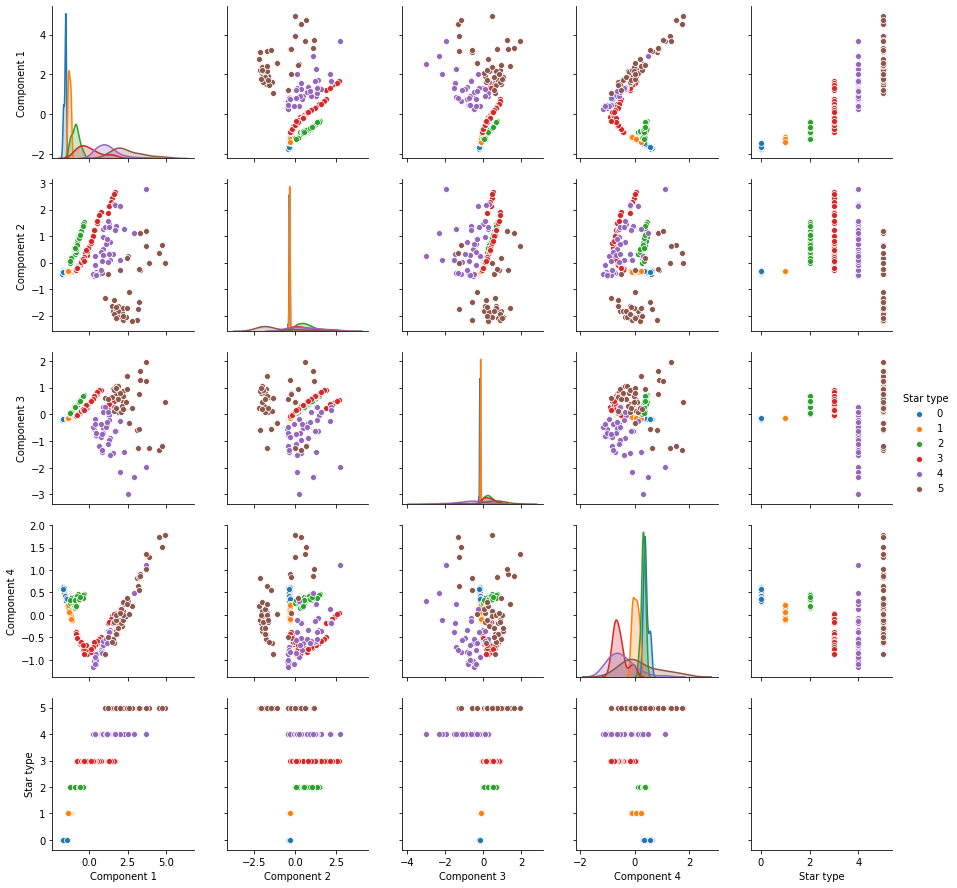

In [23]:
pca_continous_dataframe = pd.DataFrame(data=c_continous_data).transpose()
pca_continous_dataframe['Star type'] = starData['Star type']
pca_continous_dataframe.columns = ['Component 1','Component 2','Component 3',
                     'Component 4', 'Star type']

scatterplot = sns.pairplot(pca_continous_dataframe[['Component 1','Component 2','Component 3',
                     'Component 4','Star type']], hue="Star type")


[0.60357391 0.83858175 0.9318782  1.        ]


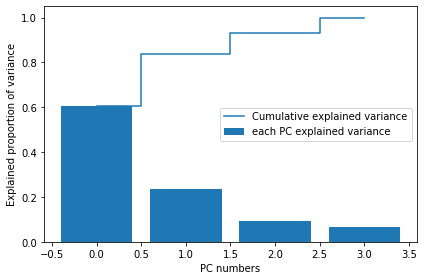

In [24]:
total_egnvalues = sum(eigvals)
exp_prop_var=[]
for i in (eigvals):
    exp_prop_var.append(i/total_egnvalues) 
                 
cum_exp_var = np.cumsum(exp_prop_var)
# visualizing culmulative expalined and variance and the number of PC that it needs to get there
print(cum_exp_var)
plt.bar(range(0,len(exp_prop_var)), exp_prop_var, label='each PC explained variance')
plt.step(range(0,len(cum_exp_var)), cum_exp_var, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained proportion of variance')
plt.xlabel('PC numbers')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

[0.60357391 0.83858175 0.9318782  1.        ]


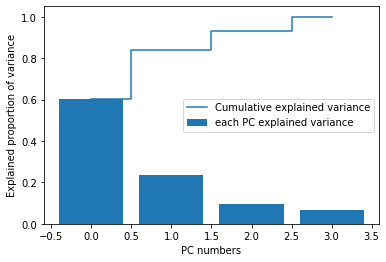

In [25]:
# Using PCA package to double check our error and varinace, whether we have the appropriate covariance matrix, and 
#we can select the threshhold number for PCA expalined variance

pca = PCA(0.99)
X = pca.fit_transform(data_woLabel)

# Determine explained variance using explained_variance_ration_ attribute
exp_prop_var = pca.explained_variance_ratio_

# Cumulative explained variance; It will help us to determine the number of principal compoents to use 
#based on our threshhold 0.8in our case

cum_exp_var = np.cumsum(exp_prop_var)
print(cum_exp_var)
# visualizing culmulative expalined and variance and the number of PC that it needs to get there

plt.bar(range(0,len(exp_prop_var)), exp_prop_var, label='each PC explained variance')
plt.step(range(0,len(cum_exp_var)), cum_exp_var, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained proportion of variance')
plt.xlabel('PC numbers')
plt.legend(loc='best')
plt.show()

# Clustering Algorithms

With this project, we set out to cluster the data into star types using unsupervised methods. Our hope was that by using PCA and Spectral Clustering in conjunction we could get high-accuracy clustering results. After demonstrating above that PCA is a necessary step for us to successfully cluster the data and noting the differences between the inclusion and exclusion of categorical variables as one-hot encodings, we are now ready to attempt the clustering section of the analysis. As we set out to use Spectral clustering, we consider this our primary algorithm, but we also included results from k-means and mixture of gaussians to demonstrate that it was the optimal approach. While using these algorithms, we include enough principle components to reach a cumulative explained variance higher than 0.9. Furthermore, we calculate the Rand index for each algorithm as a method to compare the similarity of the found clusters with the ground-truth values. 

## Algorithms on PCA with all Data included

We first provide a graph of the first two principle components to act as a visual comparison. Furthermore, we use the first 9 principle components, as they capture over 90% of the variance.

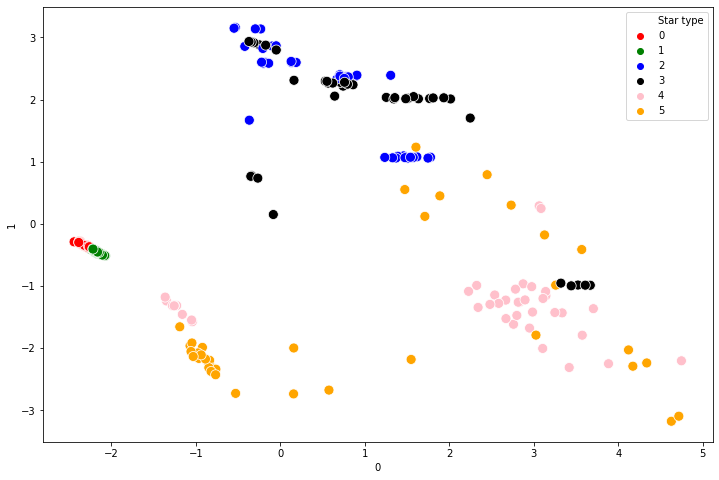

In [27]:
all_data_df = pd.DataFrame(c_full_data.T)
plt.figure(figsize=(12,8))
sns.scatterplot(all_data_df[0], all_data_df[1],
                hue=starData['Star type'],
                s=100, palette = ['red', 'green', 'blue', 'black', 'pink', 'orange'])

### K-means

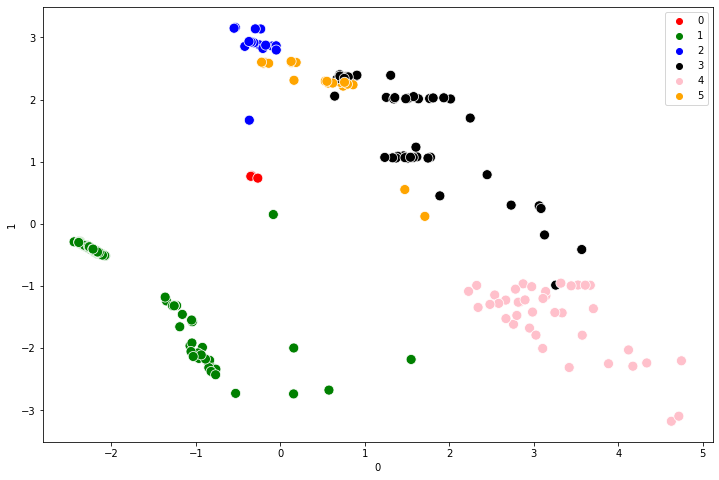

In [28]:
kmeans = KMeans(n_clusters=6).fit(np.array(all_data_df.iloc[:, : 9]))
plt.figure(figsize=(12,8))
sns.scatterplot(all_data_df[0], all_data_df[1],
                hue=kmeans.predict(np.array(all_data_df.iloc[:, : 9])),
                s=100, palette = ['red', 'green', 'blue', 'black', 'pink', 'orange'])

In [29]:
adjusted_rand_score(kmeans.predict(np.array(all_data_df.iloc[:, : 9])), starData['Star type'])

0.2698910969793322

### Mixture of Gaussians

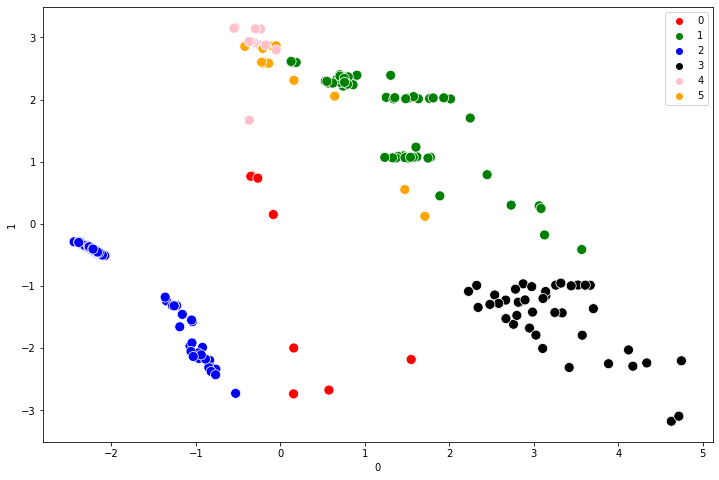

In [30]:
gm = GaussianMixture(n_components=6,
                     init_params = 'kmeans',
                     n_init=200).fit(np.array(all_data_df.iloc[:, : 9]))

plt.figure(figsize=(12,8))
sns.scatterplot(all_data_df[0], all_data_df[1],
                hue=gm.predict(np.array(all_data_df.iloc[:, : 9])),
                s=100, palette = ['red', 'green', 'blue', 'black', 'pink','orange'])

In [31]:
adjusted_rand_score(gm.predict(np.array(all_data_df.iloc[:, : 9])), starData['Star type'])

0.28943708413894864

### Spectral Clustering

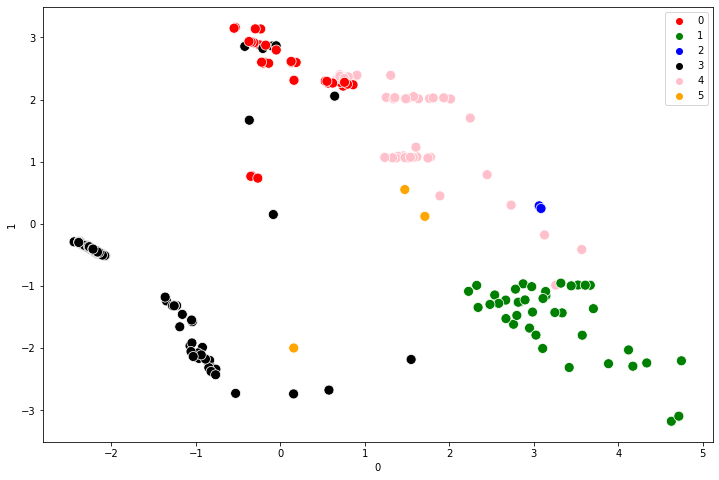

In [43]:
# With Labels using nearest neighbors n = 18
clustering1 = SpectralClustering(n_clusters=6,
                                assign_labels='discretize',
                               gamma = 3).fit(np.array(all_data_df.iloc[:, : 9]))
plt.figure(figsize=(12,8))
sns.scatterplot(all_data_df[0], all_data_df[1],
                hue=clustering1.labels_,
                s=100, palette = ['red', 'green', 'blue', 'black', 'pink', 'orange'])

In [44]:
adjusted_rand_score(clustering1.labels_, starData['Star type'])

0.25996870422592205

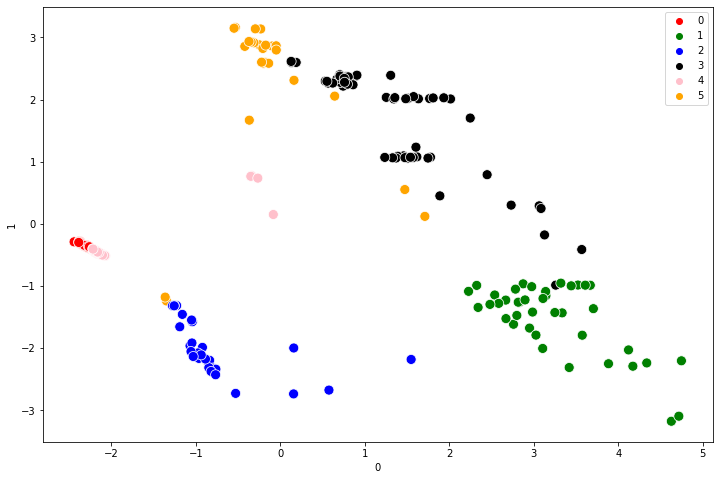

In [37]:
# With Labels using nearest neighbors n = 18
clustering2 = SpectralClustering(n_clusters=6,
                                assign_labels='discretize',
                               affinity = "nearest_neighbors",
                               n_neighbors = 18).fit(np.array(all_data_df.iloc[:, : 9]))
plt.figure(figsize=(12,8))
sns.scatterplot(all_data_df[0], all_data_df[1],
                hue=clustering2.labels_,
                s=100, palette = ['red', 'green', 'blue', 'black', 'pink', 'orange'])

In [38]:
adjusted_rand_score(clustering2.labels_, starData['Star type'])

0.5536474793362324

## Algorithms on PCA with only Continous Data

We first provide a graph of the first two principle components to act as a visual comparison. Furthermore, we use the first 3 principle components, as they capture over 90% of the variance.

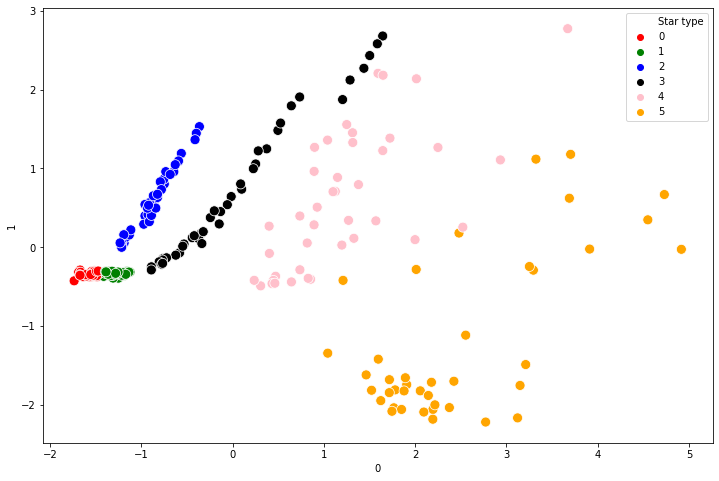

In [45]:
continous_df = pd.DataFrame(c_continous_data.T)
plt.figure(figsize=(12,8))
sns.scatterplot(continous_df[0], continous_df[1],
                hue=starData['Star type'],
                s=100, palette = ['red', 'green', 'blue', 'black', 'pink', 'orange'])

### K-means

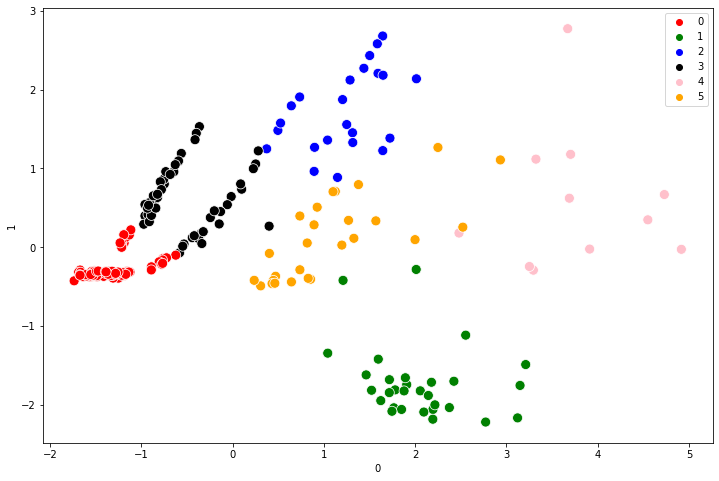

In [46]:
kmeans2 = KMeans(n_clusters=6).fit(np.array(continous_df.iloc[:, : 3]))
plt.figure(figsize= (12,8))
sns.scatterplot(continous_df[0], continous_df[1],
                hue=kmeans2.predict(np.array(continous_df.iloc[:, : 3])),
                s=100, palette = ['red', 'green', 'blue', 'black', 'pink', 'orange'])

In [47]:
adjusted_rand_score(kmeans2.predict(np.array(continous_df.iloc[:, : 3])), starData['Star type'])

0.4165814965401597

### Gaussian Mixture

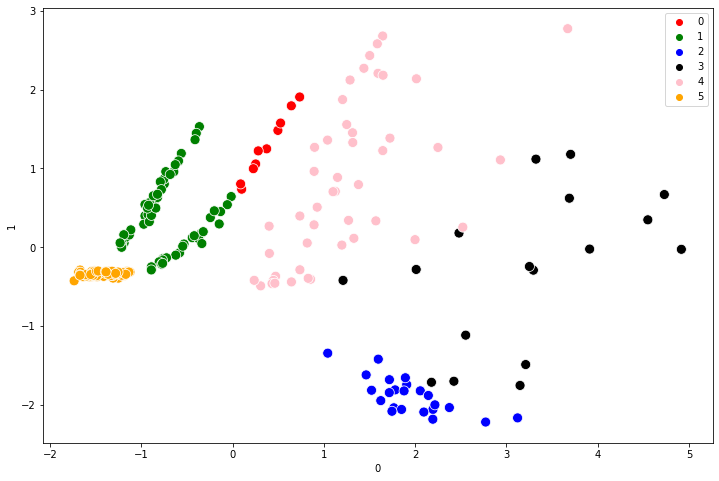

In [48]:
gm2 = GaussianMixture(n_components=6,
                     init_params = 'kmeans',
                     n_init=200).fit(np.array(continous_df.iloc[:, : 3]))

plt.figure(figsize=(12,8))
sns.scatterplot(continous_df[0], continous_df[1],
                hue=gm2.predict(np.array(continous_df.iloc[:, : 3])),
                s=100, palette = ['red', 'green', 'blue', 'black', 'pink','orange'])

In [49]:
adjusted_rand_score(gm2.predict(np.array(continous_df.iloc[:, : 3])), starData['Star type'])

0.6030072679831746

### Spectral Clustering

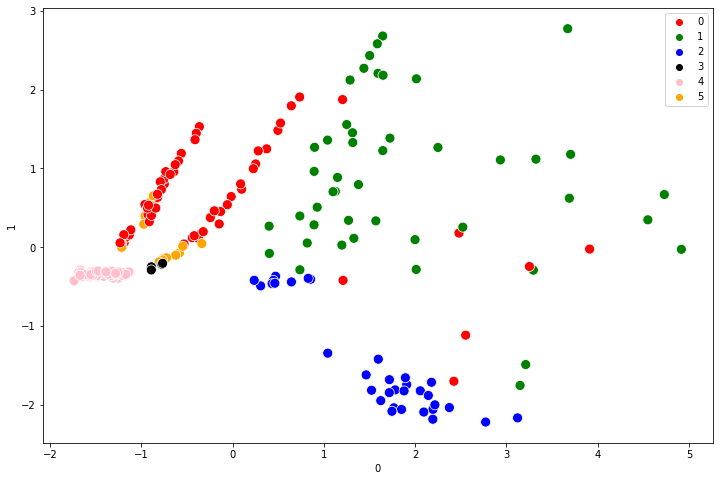

In [79]:
clustering3 = SpectralClustering(n_clusters=6,
                                assign_labels='discretize',
                               gamma = .38).fit(np.array(all_data_df.iloc[:, : 3]))
plt.figure(figsize=(12,8))
sns.scatterplot(continous_df[0], continous_df[1],
                hue=clustering3.labels_,
                s=100, palette = ['red', 'green', 'blue', 'black', 'pink', 'orange'])

In [80]:
adjusted_rand_score(clustering3.labels_, starData['Star type'])

0.46081169962051843

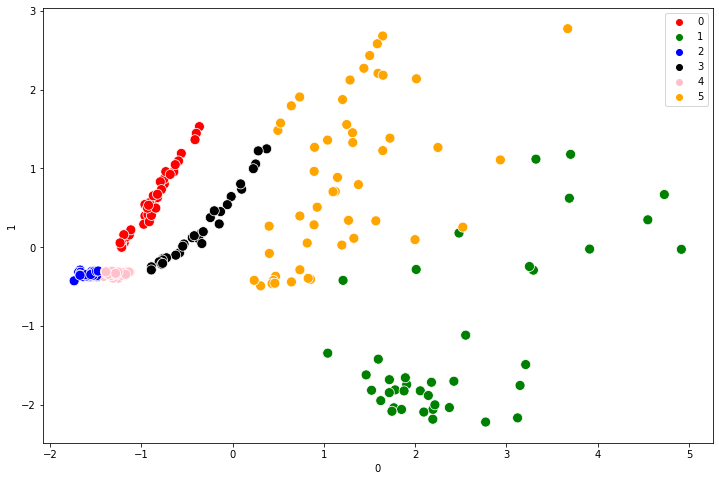

In [81]:
# using nearest neighbors n = 18 to construct affinity matrix
clustering4 = SpectralClustering(n_clusters=6,
                                assign_labels='discretize',
                               affinity = "nearest_neighbors",
                               n_neighbors = 12).fit(np.array(continous_df.iloc[:, : 3]))
plt.figure(figsize=(12,8))
sns.scatterplot(continous_df[0], continous_df[1],
                hue=clustering4.labels_,
                s=100, palette = ['red', 'green', 'blue', 'black', 'pink', 'orange'])

In [82]:
adjusted_rand_score(clustering4.labels_, starData['Star type'])

0.9113924050632911